In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from google.cloud import language

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/paul/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Define paths

DATA_DIR = './data/'
LIAR_DIR = DATA_DIR + 'liar/'

In [3]:
# Load data, with properly named columns
cols = ["ID", "label", "statement", "subject", "speaker", "job", "state", "party", "barely_true_cts",
        "false_cts", "half_true_cts", "mostly_true_cts", "pants_on_fire_cts", "context"]
    
df_raw = pd.read_table(LIAR_DIR + 'train.tsv', header=None)
df_raw.columns = cols
df_raw.head()

,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


## Sentiment analysis

One approach to feature augmentation we considered is using sentiment analysis. In the following, we use the nltk library to extract the sentiment of each statement.

For each statement, we can extract 4 metrics: negativity, positivity, neutrality and a compound value of all of these metrics.

An interesting observation is that for all 6 available truth labels, all the metrics follow the same distribution, suggesting that the dataset is well balanced in this regard.

We have chosen the nltk library due to its flexibility. The above analysis is based on the *vader lexicon*, which might not generalize well to the type of statements in this datset. However, the library provides a classifier that we plan to train on this dataset and repeat this analysis.

In [5]:
# Define a utility to perform sentiment analysis using nltk
nltk_analyzer = SentimentIntensityAnalyzer()

def nltk_sentiment(statement):
    return nltk_analyzer.polarity_scores(statement)

In [6]:
# Add sentiment analysis to the dataframe
data_with_sentiments = pd.DataFrame([nltk_sentiment(row) for row in df_raw.statement]).join(df_raw)

In [7]:
data_with_sentiments.head(5)

,compound,neg,neu,pos,ID,label,statement,subject,speaker,job,state,party,barely_true_cts,false_cts,half_true_cts,mostly_true_cts,pants_on_fire_cts,context
0,0.2500,0.115,0.692,0.192,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,0.3612,0.000,0.902,0.098,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,0.3182,0.107,0.687,0.206,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,0.7579,0.000,0.606,0.394,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,0.0000,0.000,1.000,0.000,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


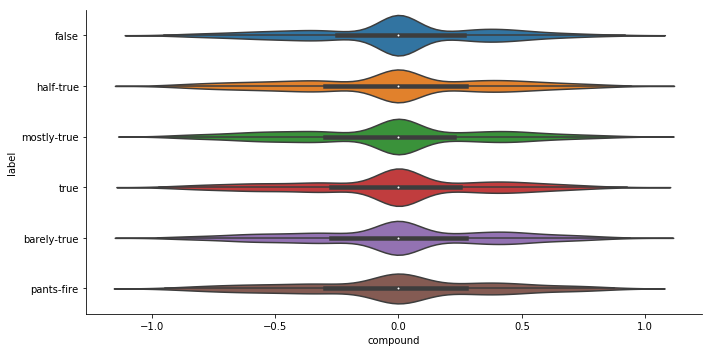

In [29]:
# Visualize the distribuiton of the sentiments over the labels
ax = sns.catplot(x='compound', y='label', data=data_with_sentiments, kind="violin", aspect=2)

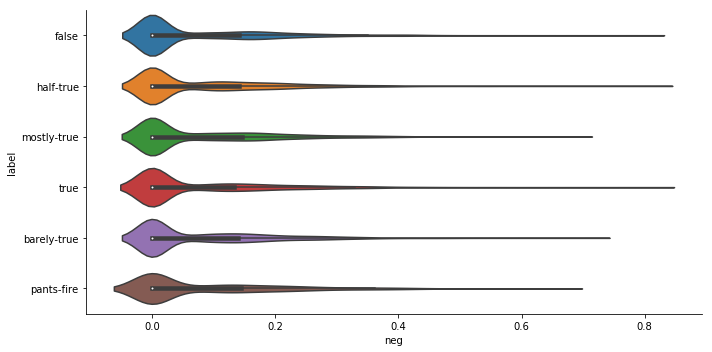

In [31]:
ax = sns.catplot(x='neg', y='label', data=data_with_sentiments, kind="violin", aspect=2)

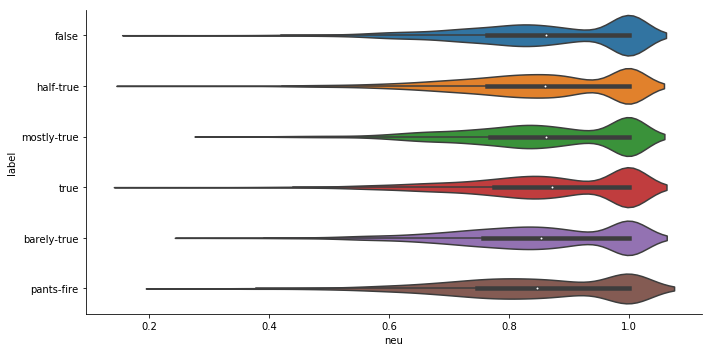

In [32]:
ax = sns.catplot(x='neu', y='label', data=data_with_sentiments, kind="violin", aspect=2)

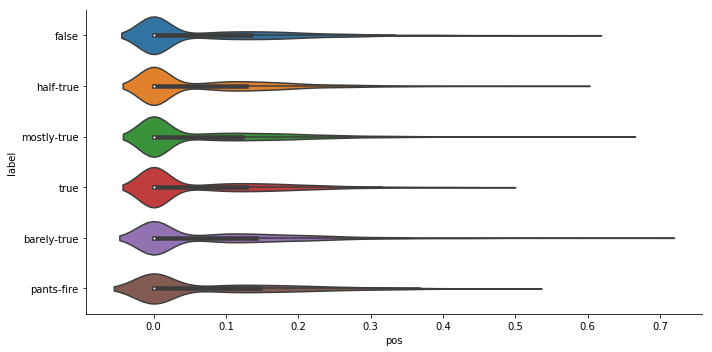

In [34]:
ax = sns.catplot(x='pos', y='label', data=data_with_sentiments, kind="violin", aspect=2)

We also tried using google cloud for sentiment analysis.

While it is not trainable as nltk, it seems to have a better accuracy at detecting subtle nuances of the language, such as the negativity in 'used to be good', reporting a sentiment of -0.2 (on a scale from -1 to 1), while nltk reports a positive sentiment almost 0.5.

We think that while nltk can provide a good insight after training its classifier on this specific dataset, google cloud has better performance for feature augmentation, providing more accurate metric.

In the following we perform a similar analysis with google cloud, but only on a fraction of the dataset due to API limits and time constraints, with the purpose of demonstrating its usefulness for this task.

In [12]:
# Similar as before, we define a utility to run the google cloud sentiment analysis
def gc_sentiment(text):  
    path = 'ADA LIAR-92a0c6a1e60e.json'
    client = language.LanguageServiceClient.from_service_account_json(path)
    document = language.types.Document(
            content=text,
            type=language.enums.Document.Type.PLAIN_TEXT)
    annotations = client.analyze_sentiment(document=document)
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude
    return score, magnitude

In [13]:
# Take a sample of the data, due to API and time limitations
sample_size = 500
df_sample = df_raw.sample(sample_size)

In [14]:
# Run Google cloud NLP analysis
gc_results = [gc_sentiment(row) for row in tqdm(df_sample.statement)]

100%|██████████| 500/500 [07:23<00:00,  1.09it/s]


In [35]:
gc_score, gc_magnitude = zip(*gc_results)
gc = list(zip(df_sample.ID, gc_score, gc_magnitude))
gc_df = pd.DataFrame(gc, columns=['ID', 'score', 'magnitude'])

In [36]:
merged = gc_df.merge(df_raw)

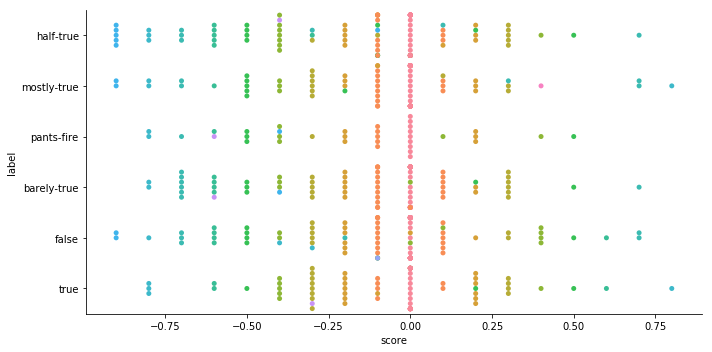

In [37]:
sns.catplot(x='score', y='label', data=merged, kind="swarm", hue='magnitude', legend=False, aspect=2);